## Setup, data, and functions

##### Importing libraries 


In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
from itertools import product   
import sys
import os

##### Expontential population model


In [2]:
### population model
def system_ode_rk45(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    kg = params[0] #growth rate
    km = params[1] #mutation rate
    kd = params[2] #death rate

    dSpop_dt = Spop * (kg - km - kd)
    dRpop_dt = Rpop * kg + Spop * km
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_rk45(params, time, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    
    pred_data_rk = solve_ivp(system_ode_rk45, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data_rk.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_rk.y[0]
        rpop = pred_data_rk.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error



##### Logistic population model


In [3]:
# Logistic population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication

    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30


    return msq_error


#####  Gompertizian

In [4]:
# Gompertizian population model
def system_ode_gompertizian(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1

    dSpop_dt = r *np.log(kmax/(Spop+Rpop)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop))*Rpop

    #print(r, kmax, lam, Spop, Rpop, dSpop_dt, dRpop_dt)

    # print(f"{kmax/(Spop+Rpop):<20} {np.log(kmax/(Spop+Rpop))}")
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


##### Von Bertalanffy population model

In [5]:
#  vonBertalanffy population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    lam = params[1] #scaling factor
    beta = params[2] # proportionality constant

    #dSpop_dt = r *Spop^lam - beta * (Spop + Rpop)
    #dRpop_dt = r*
    
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30


    return msq_error


##### Reading in data

In [6]:
# Reading data
df = pd.read_csv("C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1002,A1015 and E1034 have 4 or fewer data points
df_anyue = pd.read_excel("C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Individual parameters_START_TKI patients_AYin.xlsx") 
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # A1001,A1003,A1015 and E1034 have 4 or fewer data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]



In [28]:
df.loc[df['ID'].isin(['A1016'])]

,days,sum_tumor_lengths,Sum_tumor_volume,ID
112,0,116.0,33217.333333,A1016
113,56,49.0,2167.166667,A1016
114,97,51.0,2311.500000,A1016
115,137,48.0,1936.000000,A1016
116,193,46.0,1670.666667,A1016
117,235,44.0,1589.333333,A1016
118,271,43.0,1711.166667,A1016
119,313,52.0,2186.666667,A1016
120,354,52.0,2186.666667,A1016
121,410,54.0,2533.000000,A1016


## Running models

##### Logistic model (sensitive and resistant are not fixed)

In [9]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

    # fitting patient data to equations
    bounds = [(0, np.inf), (1, np.inf), (0, np.inf), (0, data[0]), (0, data[0])]
    init_params = [2e-3, 1, 1e-2, data[0]/2, data[0]/2] # parameters to be optimized are (kg, km, kd, Spop_0, Rpop_0) 
    opt_result_log = minimize(cost_func_logistic, init_params, args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 
    # store the optimal parameters and the cost function value (last entry in list)

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9


KeyboardInterrupt: 

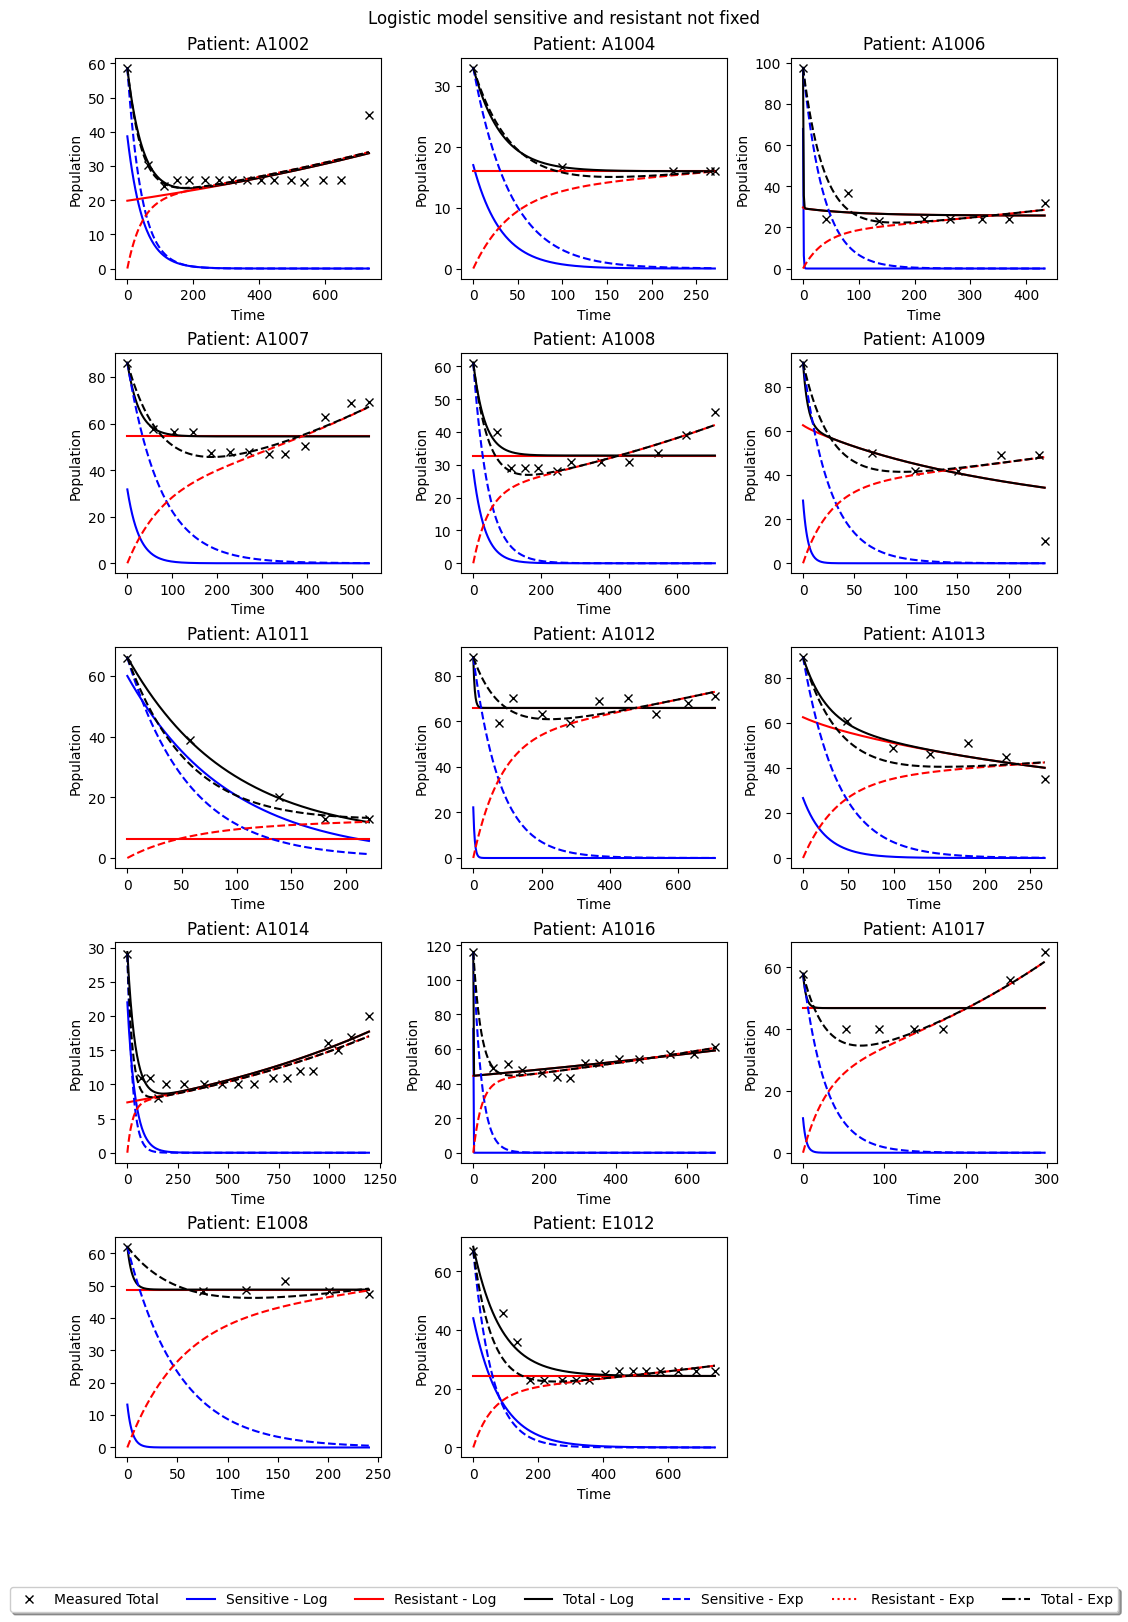

In [25]:
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    # sum_pops = np.sum(pred_data_opt.sol(tspan), axis=0)
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)
    
    #Using anyue's parameters
    anyue_params = df_anyue[df_anyue.ID == id].values.tolist()[0][1:]
    init_populations_anyue = [data[0], 0]
    pred_data_anyue = solve_ivp(system_ode_rk45, [0,days[-1]],
                                init_populations_anyue, dense_output=True,
                                args = tuple([anyue_params]))
    sum_pops_anyue = np.sum(pred_data_anyue.sol(tspan), axis=0)

    ax = axs.flatten()[(index)%len(unique_IDs)]  

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points

    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

    ax.plot(tspan, pred_data_anyue.sol(tspan)[0], 'b--', label='Sensitive - Exp')
    ax.plot(tspan, pred_data_anyue.sol(tspan)[1], 'r--', label='Resistant - Exp') # plot anyue's model
    ax.plot(tspan, sum_pops_anyue, 'k--', label='Total - Exp')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

    # Hide empty subplots
for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') 

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),
                   Line2D([0], [0], color='b', linestyle= '--' ,label='Sensitive - Exp'),
                   Line2D([0], [0], color='r', linestyle= ':' ,label='Resistant - Exp'),
                   Line2D([0], [0], color='k', linestyle= '-.' ,label='Total - Exp')]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)

fig.suptitle('Logistic model sensitive and resistant not fixed')  

plt.show()

In [26]:
df_logistic_not_fixed = pd.DataFrame.from_dict(master_dictionary, orient='index', columns=['kg',

                                                                                'km',
                                                                                'kd',
                                                                                'spop_0',
                                                                                'rpop_0','mse'
                                                                                ])
                                                                                
#df_logistic_not_fixed.to_csv('C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Logistic_model_sens_res_not_fixed.csv')
df_logistic_not_fixed  #saving parameters and mse for logistic model with sensitive and resistant not fixed

,kg,km,kd,spop_0,rpop_0,mse
A1002,7.280408e-04,6059.983928,0.021763,38.663573,19.829567,14.400239
A1004,1.046861e-10,5.037056,0.032148,17.006215,15.993764,0.000013
A1006,9.396782e-03,25.714793,1.637190,67.855164,29.744824,18.742911
A1007,4.469995e-20,4.920185,0.038014,31.721035,54.469916,59.710653
A1008,0.000000e+00,1.013289,0.029376,28.346747,32.857367,26.044864
A1009,5.697517e-05,1.000000,0.209277,28.422835,62.577148,135.127052
A1011,6.211065e-11,1.290258,0.010723,59.956172,6.156886,0.974418
A1012,0.000000e+00,2.767205,0.230391,22.200034,65.799991,18.287999
A1013,3.300154e-05,1.000000,0.037540,26.599837,62.454642,11.488718
A1014,7.338667e-04,22117.462473,0.025803,21.995965,7.363454,1.869996


##### Logistic model - fixed sensitive and resistant

In [7]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    #print("Working on patient:", id, " Number of data points:", len(days))

    # fitting patient data to equations
    bounds = [(0, np.inf), (1, np.inf), (0, np.inf), (0, data[0]), (0, np.inf)]
    init_params = [2e-3, 1, 1e-2, data[0], 0] # parameters to be optimized are (kg, km, kd, Spop_0, Rpop_0) 
    opt_result_log = minimize(cost_func_logistic, init_params, args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 
    # store the optimal parameters and the cost function value (last entry in list)

NameError: name 'df' is not defined

A1002 Optimal parameters: [0.03721588653367601, 27.22688262256022, 0.0, 58.7, 0.19512418812047203, 21.909967334777267]
A1004 Optimal parameters: [0.0252942614008608, 15.982252807349223, 0.0, 33.0, 0.0, 5.824342887319896e-05]
A1006 Optimal parameters: [0.1443580012450867, 26.42521650124498, 0.0, 97.59999999999025, 0.0, 19.291999344097363]
A1007 Optimal parameters: [0.0, 1.0, 0.0, 86.2, 0.0, 969.1899999999999]
A1008 Optimal parameters: [0.024097772514475937, 32.90674414511325, 0.0, 61.0, 0.00012992816626075012, 26.413044937523168]
A1009 Optimal parameters: [0.006719759931115005, 29.863338820272368, 0.0, 91.0, 0.020470220879091266, 139.76082103790216]
A1011 Optimal parameters: [0.0, 73.37725945949538, 0.00867301021876135, 66.0, 0.3016955027779104, 2.4874518630235074]
A1012 Optimal parameters: [0.0, 1.0, 0.0, 88.0, 0.0, 461.84399999999994]
A1013 Optimal parameters: [0.0, 1.0, 0.003914401095322241, 89.0, 0.0, 66.04493941937761]
A1014 Optimal parameters: [0.09931710843839839, 12.003444125685

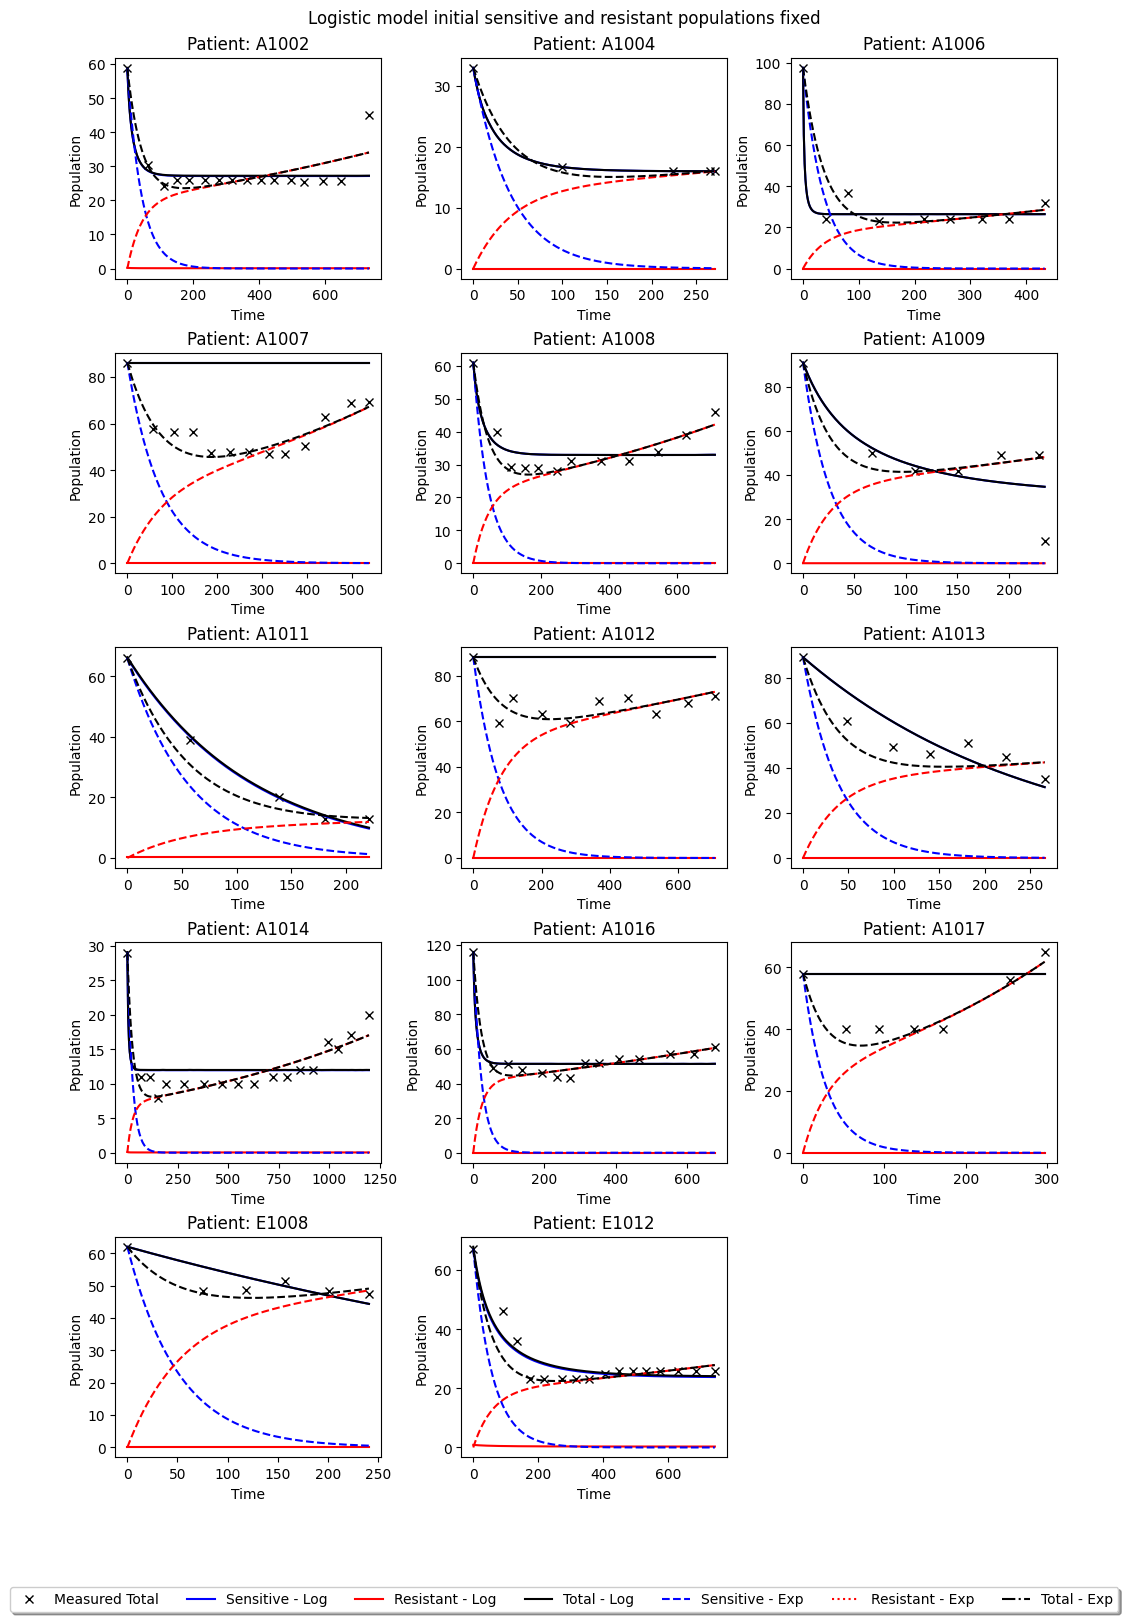

In [28]:
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    print(id,"Optimal parameters:", master_dictionary[id])

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = optimal_params_log[3:-1]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    # sum_pops = np.sum(pred_data_opt.sol(tspan), axis=0)
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)
    
    #Using anyue's parameters
    anyue_params = df_anyue[df_anyue.ID == id].values.tolist()[0][1:]
    init_populations_anyue = [data[0], 0]
    pred_data_anyue = solve_ivp(system_ode_rk45, [0,days[-1]],
                                init_populations_anyue, dense_output=True,
                                args = tuple([anyue_params]))
    sum_pops_anyue = np.sum(pred_data_anyue.sol(tspan), axis=0)

    ax = axs.flatten()[(index)%len(unique_IDs)]  

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points

    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

    ax.plot(tspan, pred_data_anyue.sol(tspan)[0], 'b--', label='Sensitive - Exp')
    ax.plot(tspan, pred_data_anyue.sol(tspan)[1], 'r--', label='Resistant - Exp') # plot anyue's model
    ax.plot(tspan, sum_pops_anyue, 'k--', label='Total - Exp')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}')  

    # Hide empty subplots
for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off')

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),
                   Line2D([0], [0], color='b', linestyle= '--' ,label='Sensitive - Exp'),
                   Line2D([0], [0], color='r', linestyle= ':' ,label='Resistant - Exp'),
                   Line2D([0], [0], color='k', linestyle= '-.' ,label='Total - Exp')]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)

fig.suptitle('Logistic model initial sensitive and resistant populations fixed')  

plt.show()

In [29]:
df_logistic_fixed = pd.DataFrame.from_dict(master_dictionary, orient='index', columns=['kg',
                                                                                       'km',
                                                                                       'kd',
                                                                                       'spop_0',
                                                                                       'rpop_0',
                                                                                       'mse'
                                                                                       ])
                                                                                
#df_logistic_not_fixed.to_csv('C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Logistic_model_sens_res_not_fixed.csv')
df_logistic_fixed  #saving parameters and mse for logistic model with sensitive and resistant not fixed

,kg,km,kd,spop_0,rpop_0,mse
A1002,0.037216,27.226883,0.000000,58.7,0.195124,21.909967
A1004,0.025294,15.982253,0.000000,33.0,0.000000,0.000058
A1006,0.144358,26.425217,0.000000,97.6,0.000000,19.291999
A1007,0.000000,1.000000,0.000000,86.2,0.000000,969.190000
A1008,0.024098,32.906744,0.000000,61.0,0.000130,26.413045
A1009,0.006720,29.863339,0.000000,91.0,0.020470,139.760821
A1011,0.000000,73.377259,0.008673,66.0,0.301696,2.487452
A1012,0.000000,1.000000,0.000000,88.0,0.000000,461.844000
A1013,0.000000,1.000000,0.003914,89.0,0.000000,66.044939
A1014,0.099317,12.003444,0.000000,29.0,0.102752,8.765927


In [30]:
print(df_logistic_not_fixed.mse.mean())
print(df_logistic_fixed.mse.mean())

28.055424896920886
140.10077047293362


##### Exponential - initial populations not fixed 

In [31]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()

    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

    # fitting patient data to equations
    bounds = [(0, np.inf), (1, np.inf), (0, np.inf), (0, data[0]), (0, data[0])]
    init_params = [2e-3, 1, 1e-2, data[0]/2, data[0]/2] # parameters to be optimized are (kg, km, kd, Spop_0, Rpop_0) 
    opt_result_exp = minimize(cost_func_rk45, init_params, args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_exp.x.tolist() + [opt_result_exp.fun] 
    # store the optimal parameters and the cost function value (last entry in list)

Working on patient: A1002  Number of data points: 16


In [ ]:
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    print(id,"Optimal parameters:", master_dictionary[id])

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_rk45, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)
    
    #Using anyue's parameters
    anyue_params = df_anyue[df_anyue.ID == id].values.tolist()[0][1:]
    init_populations_anyue = [data[0], 0]
    pred_data_anyue = solve_ivp(system_ode_rk45, [0,days[-1]],
                                init_populations_anyue, dense_output=True,
                                args = tuple([anyue_params]))
    sum_pops_anyue = np.sum(pred_data_anyue.sol(tspan), axis=0)

    ax = axs.flatten()[(index)%len(unique_IDs)]  

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive ')# plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant')  
    ax.plot(tspan, sum_pops, 'k-', label='Total')

    ax.plot(tspan, pred_data_anyue.sol(tspan)[0], 'b--', label='Sensitive - Anyue')
    ax.plot(tspan, pred_data_anyue.sol(tspan)[1], 'r--', label='Resistant - Anyue') # plot anyue's model
    ax.plot(tspan, sum_pops_anyue, 'k--', label='Total - Anyue')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}')  

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),
                   Line2D([0], [0], color='b', linestyle= '--' ,label='Sensitive - Anyue'),
                   Line2D([0], [0], color='r', linestyle= ':' ,label='Resistant - Anyue'),
                   Line2D([0], [0], color='k', linestyle= '-.' ,label='Total - Anyue')]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)

fig.suptitle('Exponential model sensitive and resistant not fixed')  

plt.show()

In [ ]:
df__exp_not_fixed = pd.DataFrame.from_dict(master_dictionary, orient='index', columns=['kg',

                                                                                'km',
                                                                                'kd',
                                                                                #'spop_0',
                                                                                #'rpop_0','mse'
                                                                                ])
                                                                                
#df_exp_not_fixed.to_csv('C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Exponential_model_sens_res_not_fixed.csv')
df_exp_not_fixed  #saving parameters and mse for logistic model with sensitive and resistant not fixed

##### Exponential model, fixed initial populations 

In [ ]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()

    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

    # fitting patient data to equations
    bounds = [(0, np.inf), (1, np.inf), (0, np.inf), (0, data[0]), (0, np.inf)]
    init_params = [2e-3, 1, 1e-2, data[0], 0] # parameters to be optimized are (kg, km, kd, Spop_0, Rpop_0) 
    opt_result_exp = minimize(cost_func_rk45, init_params, args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_exp.x.tolist() + [opt_result_exp.fun] 
    # store the optimal parameters and the cost function value (last entry in list)

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 7
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


A1002 Optimal parameters: [0.0, 1.0455458549518268, 1.211115902169341, 58.7, 0.15653973310671954, 22.2638651374781]
A1004 Optimal parameters: [0.0, 1.0237239813292591, 1.06486330731257, 33.0, 1.0695800954929886e-05, 0.073499826734784]
A1006 Optimal parameters: [0.0, 1.1286277482872216, 3.0384102074869777, 97.59999999961664, 0.0034987343037002966, 19.302082105604317]
A1007 Optimal parameters: [0.0, 1.0000323998185658, 0.5774058107814102, 86.2, 0.17754172004530222, 60.52415520979404]
A1008 Optimal parameters: [0.0, 1.0072797224305936, 0.834882219899238, 61.0, 0.0001427354621873438, 28.04560515770272]
A1009 Optimal parameters: [0.0, 1.3351241065752455, 1.6786764777200176, 91.0, 0.019656913927402007, 167.04767702931932]
A1011 Optimal parameters: [0.0, 1.2164910827036792, 2.562137573503981, 66.0, 0.001968286523741769, 90.54999870336505]
A1012 Optimal parameters: [0.0, 1.0327376023228005, 0.34844266246940125, 88.0, 0.0008183261558351506, 18.28799993245909]
A1013 Optimal parameters: [0.0, 1.2

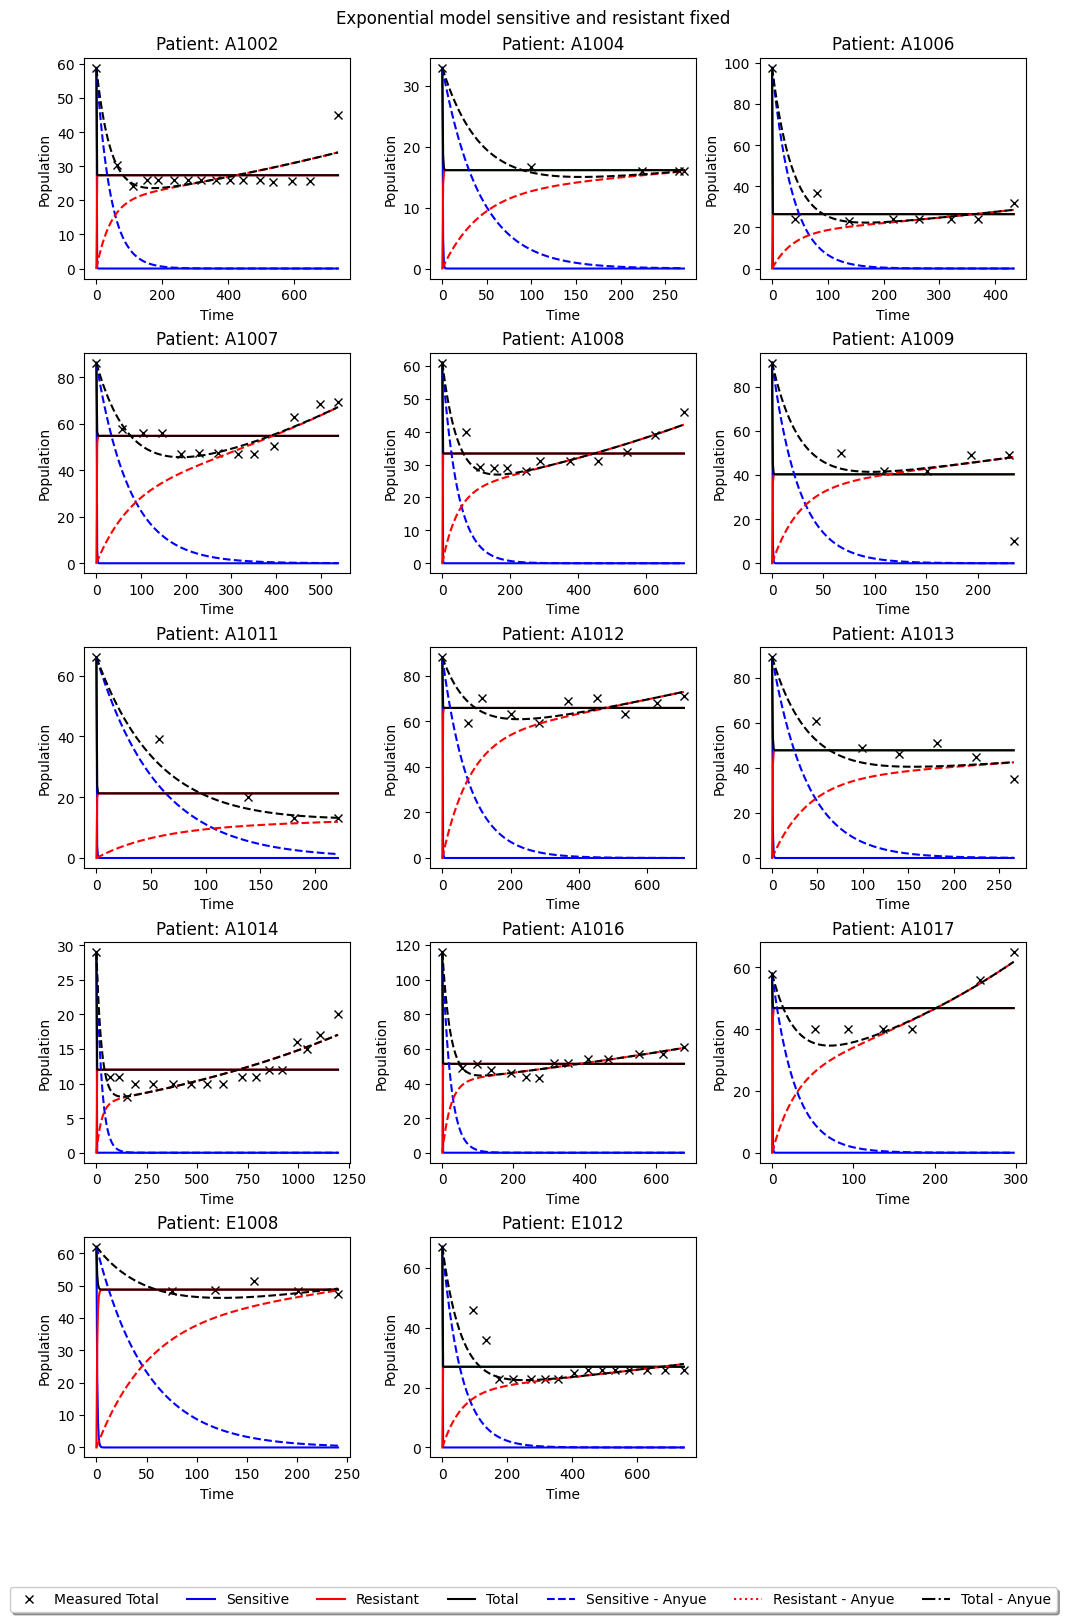

In [ ]:
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    print(id,"Optimal parameters:", master_dictionary[id])

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_rk45, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)
    
    #Using anyue's parameters
    anyue_params = df_anyue[df_anyue.ID == id].values.tolist()[0][1:]
    init_populations_anyue = [data[0], 0]
    pred_data_anyue = solve_ivp(system_ode_rk45, [0,days[-1]],
                                init_populations_anyue, dense_output=True,
                                args = tuple([anyue_params]))
    sum_pops_anyue = np.sum(pred_data_anyue.sol(tspan), axis=0)

    ax = axs.flatten()[(index)%len(unique_IDs)]  

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive ')# plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant')  
    ax.plot(tspan, sum_pops, 'k-', label='Total')

    ax.plot(tspan, pred_data_anyue.sol(tspan)[0], 'b--', label='Sensitive - Anyue')
    ax.plot(tspan, pred_data_anyue.sol(tspan)[1], 'r--', label='Resistant - Anyue') # plot anyue's model
    ax.plot(tspan, sum_pops_anyue, 'k--', label='Total - Anyue')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}')  

    # Hide empty subplots
for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off')

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),
                   Line2D([0], [0], color='b', linestyle= '--' ,label='Sensitive - Anyue'),
                   Line2D([0], [0], color='r', linestyle= ':' ,label='Resistant - Anyue'),
                   Line2D([0], [0], color='k', linestyle= '-.' ,label='Total - Anyue')]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)

fig.suptitle('Exponential model sensitive and resistant fixed')  

plt.show()

In [ ]:
df_exp_fixed = pd.DataFrame.from_dict(master_dictionary, orient='index', columns=['kg',
                                                                                'km',
                                                                                'kd',
                                                                                'spop_0',
                                                                                'rpop_0',
                                                                                'mse'
                                                                                ])
                                                                                
#df_exp_not_fixed.to_csv('C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Exponential_model_sens_res_not_fixed.csv')
df_exp_fixed  #saving parameters and mse for logistic model with sensitive and resistant not fixed

,kg,km,kd,spop_0,rpop_0,mse
A1002,0.0,1.045546,1.211116,58.7,0.156540,22.263865
A1004,0.0,1.023724,1.064863,33.0,0.000011,0.073500
A1006,0.0,1.128628,3.038410,97.6,0.003499,19.302082
A1007,0.0,1.000032,0.577406,86.2,0.177542,60.524155
A1008,0.0,1.007280,0.834882,61.0,0.000143,28.045605
A1009,0.0,1.335124,1.678676,91.0,0.019657,167.047677
A1011,0.0,1.216491,2.562138,66.0,0.001968,90.549999
A1012,0.0,1.032738,0.348443,88.0,0.000818,18.288000
A1013,0.0,1.200801,1.036973,89.0,0.009226,50.061918
A1014,0.0,1.045059,1.481180,29.0,0.003080,8.777777


##### Gompertizian model initial populations not fixed 

In [91]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    
    log_arg = kmax/(Spop + Rpop + epsilon)

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop

        # Normalize the data to prevent overflow error
        data_mean = np.mean(data)
        data_std = np.std(data)
        normalized_data = (data - data_mean) / data_std

        sum_pops_mean = np.mean(sum_pops)
        sum_pops_std = np.std(sum_pops) + epsilon
        normalized_sum_pops = (sum_pops - sum_pops_mean) / sum_pops_std

        sumsq_error = np.sum((normalized_sum_pops - normalized_data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error

### Gompertzian model
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# list of lists for possible initial parameters
init_params_list = [[2e-2,5e-2, 1e-1],                             # params list growth rate
                    [1.5*data[0], 2*data[0], 3*data[0]],      # params list K 
                    [1,2,5,10],                              # params list lambda
                    [0.5*data[0], 0.75*data[0], data[0]],   # initial params list Spop
                    ]

# initial parameters Rpop - defined relative to Spop
# init_params_list.append([data[0] - spop for spop in init_params_list[3]])

# Generate all combinations of initial parameters
init_params_combinations = list(product(*init_params_list))
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days), "starting population:", data[0],"params = r,K,lamda,Spop, Rpop" )

    for init_params in init_params_combinations:
        init_params_with_rpop = init_params + ((data[0]-init_params[3]+1e-9,))

        print(f"Initial parameters: {init_params_with_rpop}")
        bounds = [(1e-2 , np.inf),          #r
                  (1.1*data[0], np.inf),   #K
                  (0, np.inf),              #lamda
                  (1e-9, data[0]),          # Spop_0
                  (1e-9, data[0])]              # Rpop_0
        opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")
        # Store the optimized parameters and the cost function value in the dictionary
        # Use a tuple (id, tuple(init_params_with_rpop)) as the key to uniquely identify each optimization result
        master_dictionary[(id, tuple(init_params_with_rpop))] = opt_result.x.tolist() + [opt_result.fun]
    


Working on patient: A1002  Number of data points: 16 starting population: 58.7 params = r,K,lamda,Spop, Rpop
Initial parameters: (0.02, 88.05000000000001, 1, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 1, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 1, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 2, 29.35, 29.350000001)


C:\Users\lstocker\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Initial parameters: (0.02, 88.05000000000001, 2, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 2, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 5, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 5, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 5, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 10, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 10, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 10, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 1, 29.35, 29.350000001)
Initial parameters: (0.02, 117.4, 1, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 117.4, 1, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 2, 29.35, 29.350000001)
Initial parameters: (0.02, 117.4, 2, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 117.4, 2, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 

C:\Users\lstocker\AppData\Local\Temp\ipykernel_15324\3250630090.py:83: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")


Initial parameters: (0.02, 88.05000000000001, 1, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 2, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 2, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 2, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 5, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 5, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 5, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 10, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 10, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 10, 58.7, -25.699999999000003)
Initial parameters: (0.02, 117.4, 1, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 117.4, 1, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 117.4, 1, 58.7, -25.699999

In [7]:


# Convert the dictionary to a DataFrame
df2 = pd.DataFrame(list(master_dictionary.items()), columns=['ID', 'Value'])

# Set 'ID' as the index
df2.set_index('ID', inplace=True)

# Save the DataFrame as a CSV file
df2.to_csv('master_dictionary.csv')

# Loading master dictionary
master_dictionary_load = pd.read_csv('master_dictionary.csv')

In [24]:
master_dictionary_load.shape


# for row in master_dictionary_load:
#     print(master_dictionary_load['ID'][row], master_dictionary_load['value'])

(1512, 2)

In [ ]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    
    log_arg = kmax/(Spop + Rpop + epsilon)

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop

        # Normalize the data to prevent overflow error
        data_mean = np.mean(data)
        data_std = np.std(data)
        normalized_data = (data - data_mean) / data_std

        sum_pops_mean = np.mean(sum_pops)
        sum_pops_std = np.std(sum_pops) + epsilon
        normalized_sum_pops = (sum_pops - sum_pops_mean) / sum_pops_std

        sumsq_error = np.sum((normalized_sum_pops - normalized_data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error

### Gompertzian model
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# list of lists for possible initial parameters
init_params_list = [[2e-2,5e-2, 1e-1],                             # params list growth rate
                    [1.5*data[0], 2*data[0], 3*data[0]],      # params list K 
                    [1,2,5,10],                              # params list lambda
                    [0.5*data[0], 0.75*data[0], data[0]],   # initial params list Spop
                    ]

# initial parameters Rpop - defined relative to Spop
# init_params_list.append([data[0] - spop for spop in init_params_list[3]])

# Generate all combinations of initial parameters
init_params_combinations = list(product(*init_params_list))
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days), "starting population:", data[0],"params = r,K,lamda,Spop, Rpop" )

    for init_params in init_params_combinations:
        init_params_with_rpop = init_params + ((data[0]-init_params[3]+1e-9,))

        print(f"Initial parameters: {init_params_with_rpop}")
        bounds = [(1e-2 , np.inf),          #r
                  (1.1*data[0], np.inf),   #K
                  (0, np.inf),              #lamda
                  (1e-9, data[0]),          # Spop_0
                  (1e-9, data[0])]              # Rpop_0
        opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")
        # Store the optimized parameters and the cost function value in the dictionary
        # Use a tuple (id, tuple(init_params_with_rpop)) as the key to uniquely identify each optimization result
        master_dictionary[(id, tuple(init_params_with_rpop))] = opt_result.x.tolist() + [opt_result.fun]
    


Working on patient: A1002  Number of data points: 16 starting population: 58.7 params = r,K,lamda,Spop, Rpop
Initial parameters: (0.02, 88.05000000000001, 1, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 1, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 1, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 2, 29.35, 29.350000001)


C:\Users\lstocker\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Initial parameters: (0.02, 88.05000000000001, 2, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 2, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 5, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 5, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 5, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 10, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 10, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 10, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 1, 29.35, 29.350000001)
Initial parameters: (0.02, 117.4, 1, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 117.4, 1, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 2, 29.35, 29.350000001)
Initial parameters: (0.02, 117.4, 2, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 117.4, 2, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 

C:\Users\lstocker\AppData\Local\Temp\ipykernel_15324\3250630090.py:83: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")


Initial parameters: (0.02, 88.05000000000001, 1, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 2, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 2, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 2, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 5, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 5, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 5, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 10, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 10, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 10, 58.7, -25.699999999000003)
Initial parameters: (0.02, 117.4, 1, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 117.4, 1, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 117.4, 1, 58.7, -25.699999

In [ ]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    
    log_arg = kmax/(Spop + Rpop + epsilon)

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop

        # Normalize the data to prevent overflow error
        data_mean = np.mean(data)
        data_std = np.std(data)
        normalized_data = (data - data_mean) / data_std

        sum_pops_mean = np.mean(sum_pops)
        sum_pops_std = np.std(sum_pops) + epsilon
        normalized_sum_pops = (sum_pops - sum_pops_mean) / sum_pops_std

        sumsq_error = np.sum((normalized_sum_pops - normalized_data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error

### Gompertzian model
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# list of lists for possible initial parameters
init_params_list = [[2e-2,5e-2, 1e-1],                             # params list growth rate
                    [1.5*data[0], 2*data[0], 3*data[0]],      # params list K 
                    [1,2,5,10],                              # params list lambda
                    [0.5*data[0], 0.75*data[0], data[0]],   # initial params list Spop
                    ]

# initial parameters Rpop - defined relative to Spop
# init_params_list.append([data[0] - spop for spop in init_params_list[3]])

# Generate all combinations of initial parameters
init_params_combinations = list(product(*init_params_list))
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days), "starting population:", data[0],"params = r,K,lamda,Spop, Rpop" )

    for init_params in init_params_combinations:
        init_params_with_rpop = init_params + ((data[0]-init_params[3]+1e-9,))

        print(f"Initial parameters: {init_params_with_rpop}")
        bounds = [(1e-2 , np.inf),          #r
                  (1.1*data[0], np.inf),   #K
                  (0, np.inf),              #lamda
                  (1e-9, data[0]),          # Spop_0
                  (1e-9, data[0])]              # Rpop_0
        opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")
        # Store the optimized parameters and the cost function value in the dictionary
        # Use a tuple (id, tuple(init_params_with_rpop)) as the key to uniquely identify each optimization result
        master_dictionary[(id, tuple(init_params_with_rpop))] = opt_result.x.tolist() + [opt_result.fun]
    


Working on patient: A1002  Number of data points: 16 starting population: 58.7 params = r,K,lamda,Spop, Rpop
Initial parameters: (0.02, 88.05000000000001, 1, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 1, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 1, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 2, 29.35, 29.350000001)


C:\Users\lstocker\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Initial parameters: (0.02, 88.05000000000001, 2, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 2, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 5, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 5, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 5, 58.7, 1e-09)
Initial parameters: (0.02, 88.05000000000001, 10, 29.35, 29.350000001)
Initial parameters: (0.02, 88.05000000000001, 10, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 88.05000000000001, 10, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 1, 29.35, 29.350000001)
Initial parameters: (0.02, 117.4, 1, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 117.4, 1, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 2, 29.35, 29.350000001)
Initial parameters: (0.02, 117.4, 2, 44.025000000000006, 14.675000000999997)
Initial parameters: (0.02, 117.4, 2, 58.7, 1e-09)
Initial parameters: (0.02, 117.4, 

C:\Users\lstocker\AppData\Local\Temp\ipykernel_15324\3250630090.py:83: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(cost_func_gompertizian, init_params_with_rpop, args=(days, data), bounds = bounds, method="nelder-mead")


Initial parameters: (0.02, 88.05000000000001, 1, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 2, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 2, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 2, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 5, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 5, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 5, 58.7, -25.699999999000003)
Initial parameters: (0.02, 88.05000000000001, 10, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 88.05000000000001, 10, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 88.05000000000001, 10, 58.7, -25.699999999000003)
Initial parameters: (0.02, 117.4, 1, 29.35, 3.6500000009999987)
Initial parameters: (0.02, 117.4, 1, 44.025000000000006, -11.024999999000006)
Initial parameters: (0.02, 117.4, 1, 58.7, -25.699999

KeyError: 'A1002'

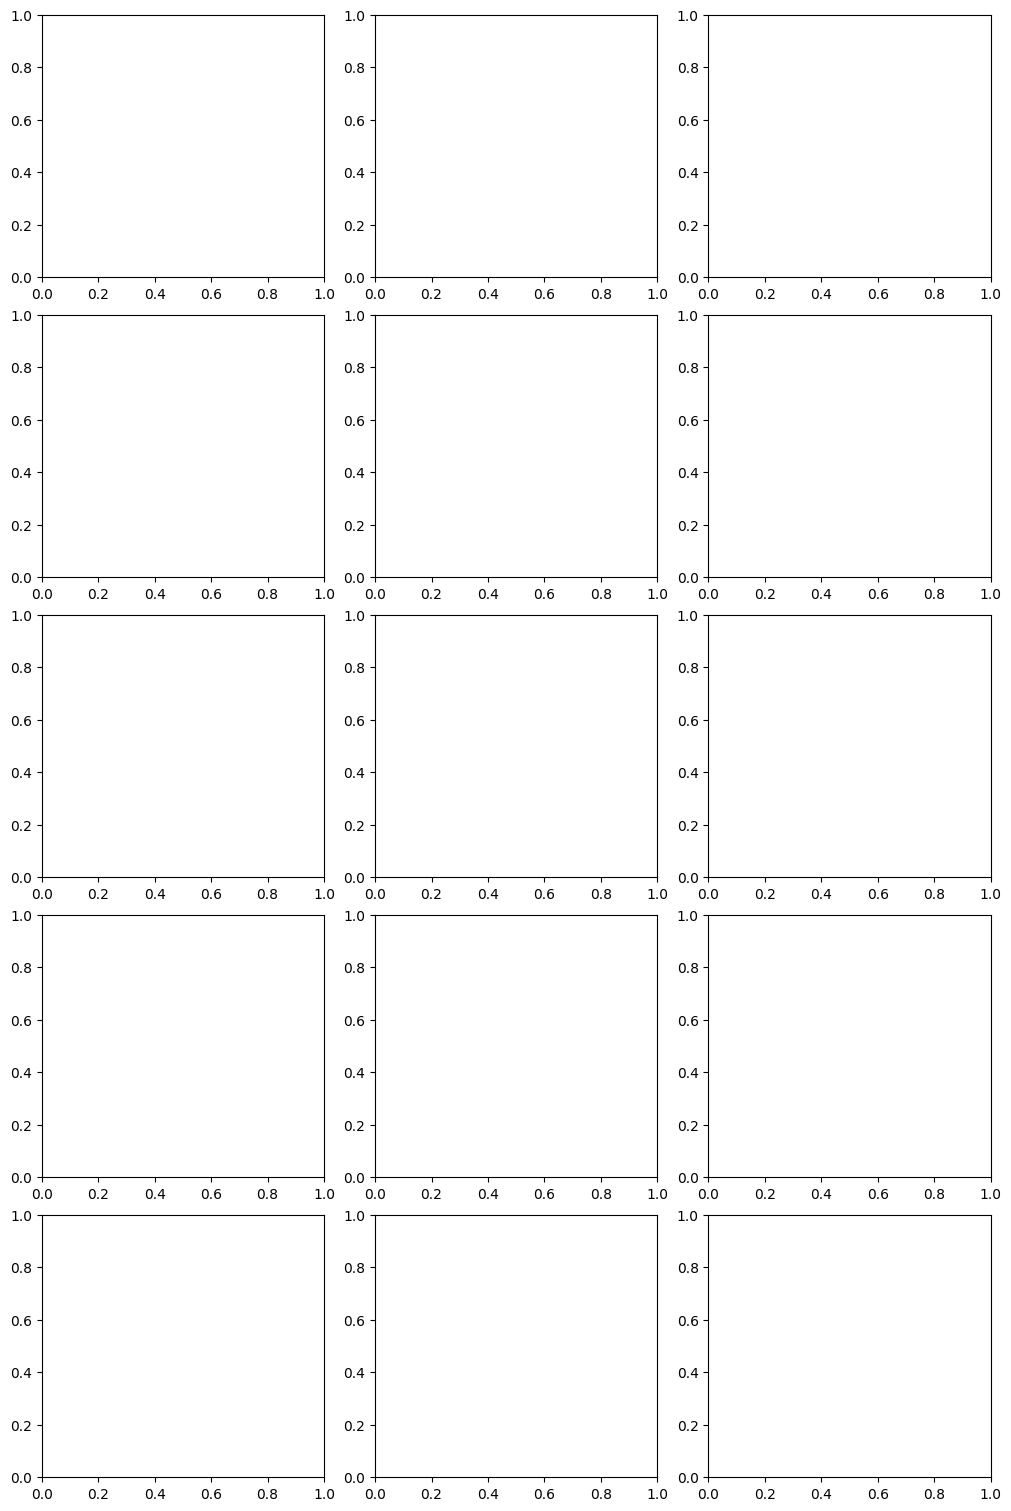

In [92]:
#### fitting Gompertizian sensitive and resistant populations not fixed  
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    print(id,"Optimal parameters:", master_dictionary[id])

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ax = axs.flatten()[(index)%len(unique_IDs)]  

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive ')# plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant')  
    ax.plot(tspan, sum_pops, 'k-', label='Total')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}')  

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total'),]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)

fig.suptitle('Gompertizian model sensitive and resistant not fixed')  

plt.show()

In [ ]:
df_gomp_not_fixed = pd.DataFrame.from_dict(master_dictionary, orient='index', columns=['r',
                                                                                'K',
                                                                                'lambda',
                                                                                'spop_0',
                                                                                'rpop_0',
                                                                                'mse'
                                                                                ])
                                                                                
#df_gomp_not_fixed.to_csv('C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Gompertzian_model_sens_res_not_fixed.csv')
df_gomp_not_fixed #saving parameters and mse for logistic model with sensitive and resistant not fixed

,r,K,lambda,spop_0,rpop_0,mse
A1001,0.000000e+00,48.900000,1.186536,10.472015,29.927985,43.765000
A1002,1.334141e-17,58.954122,0.016054,27.351414,1.961086,79.837344
A1003,0.000000e+00,107.201604,0.038771,81.997407,0.627594,330.171875
A1004,4.003164e-19,41.184408,0.009163,0.139352,19.400649,45.366400
A1006,9.351733e-18,140.825117,0.028355,1.787219,32.557226,519.460247
A1007,0.000000e+00,86.200000,0.000000,54.560098,2.678363,130.419290
A1008,0.000000e+00,79.238807,0.010992,35.658333,0.000000,86.427431
A1009,0.000000e+00,91.000021,0.000031,45.724471,1.846956,481.387755
A1011,0.000000e+00,68.655151,0.017239,30.200000,0.000000,410.960000
A1012,2.704392e-17,88.449154,0.016854,12.452115,55.567885,62.643600


##### Gompertzian model - fixed initial populations

In [ ]:
### Gompertzian model
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))
    #print(data[0])

    # fitting patient data to equations
    bounds = [(0, np.inf), (data[0],np.inf), (0,np.inf), (0, data[0]), (0, data[0])]
    init_params = [2e-2, data[0], 1, data[0], 0] # parameters to be optimized are (kg = growth rate, K, lambda = sensitivity , Spop_0, Rpop_0) 
    opt_result = minimize(cost_func_gompertizian, init_params, args=(days, data), bounds = bounds, method="nelder-mead")
    master_dictionary[id] = opt_result.x.tolist() + [opt_result.fun] 

Working on patient: A1002  Number of data points: 16


C:\Users\lstocker\AppData\Local\Temp\ipykernel_21852\2195924474.py:12: RuntimeWarning: invalid value encountered in log
  dSpop_dt = r *(np.log(kmax/(Spop+Rpop)) * (1-lam*m))*Spop
C:\Users\lstocker\AppData\Local\Temp\ipykernel_21852\2195924474.py:13: RuntimeWarning: invalid value encountered in log
  dRpop_dt = r * np.log(kmax/(Spop+Rpop))*Rpop


Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9


C:\Users\lstocker\AppData\Local\Temp\ipykernel_21852\2195924474.py:12: RuntimeWarning: overflow encountered in scalar divide
  dSpop_dt = r *(np.log(kmax/(Spop+Rpop)) * (1-lam*m))*Spop
C:\Users\lstocker\AppData\Local\Temp\ipykernel_21852\2195924474.py:13: RuntimeWarning: overflow encountered in scalar divide
  dRpop_dt = r * np.log(kmax/(Spop+Rpop))*Rpop
C:\Users\lstocker\AppData\Local\Temp\ipykernel_21852\2195924474.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  dRpop_dt = r * np.log(kmax/(Spop+Rpop))*Rpop


Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 7
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


A1001 Optimal parameters: [0.020268, 48.9, 1.0133999999999996, 48.89999999999999, 0.0, 116.01499999999987]
A1002 Optimal parameters: [0.02, 58.7, 1.0, 58.7, 0.0, 943.4625000000002]
A1003 Optimal parameters: [0.02, 107.0, 1.0, 107.0, 0.0, 924.3125]
A1004 Optimal parameters: [0.02, 33.0, 1.0, 33.0, 0.0, 226.538]
A1006 Optimal parameters: [0.020268, 97.6, 1.0133999999999996, 97.59999999999998, 0.0, 4520.725555555554]
A1007 Optimal parameters: [0.02, 86.2, 1.0, 86.2, 0.0, 969.1899999999999]
A1008 Optimal parameters: [0.02, 61.0, 1.0, 61.0, 0.0, 728.6274999999999]
A1009 Optimal parameters: [0.02, 91.0, 1.0, 91.0, 0.0, 2367.4285714285716]
A1011 Optimal parameters: [0.02, 66.0, 1.0, 66.0, 0.0, 1692.6]
A1012 Optimal parameters: [0.02, 88.0, 1.0, 88.0, 0.0, 461.84399999999994]
A1013 Optimal parameters: [0.02, 89.0, 1.0, 89.0, 0.0, 1507.3657142857141]
A1014 Optimal parameters: [0.02, 29.0, 1.0, 29.0, 0.0, 281.72222222222223]
A1017 Optimal parameters: [0.02, 58.0, 1.0, 58.0, 0.0, 192.714285714285

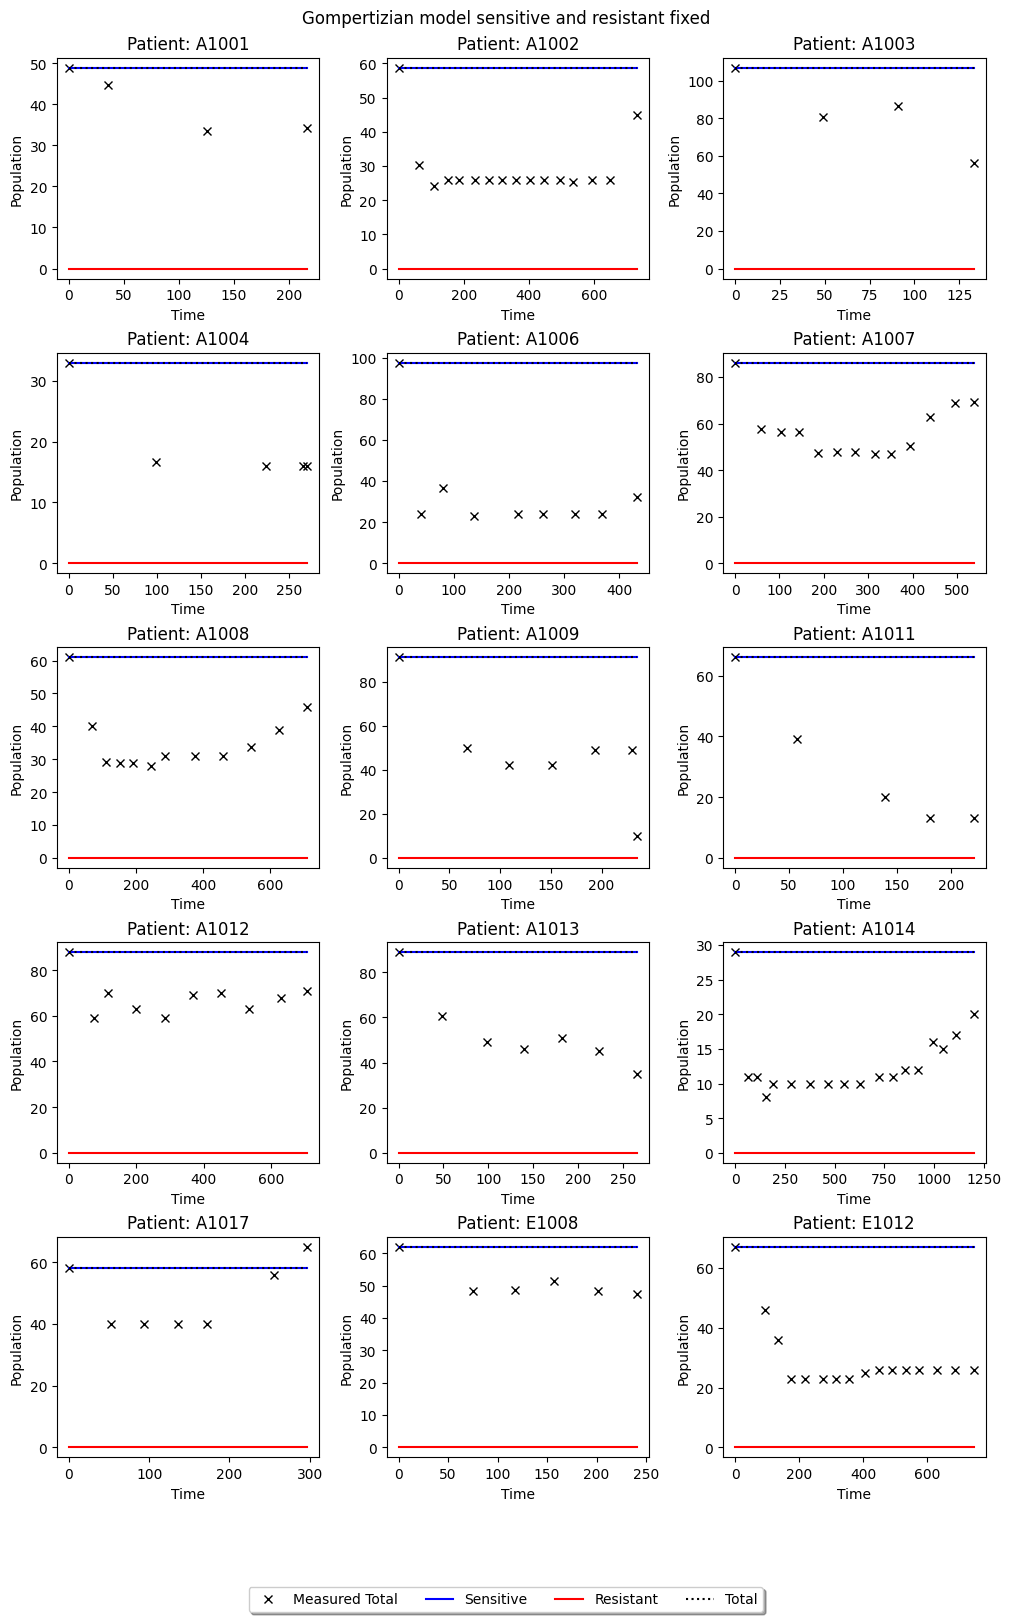

In [ ]:
#### fitting Gompertizian sensitive and resistant populations fixed  
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    print(id,"Optimal parameters:", master_dictionary[id])

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ax = axs.flatten()[(index)%len(unique_IDs)]  

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive ')# plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant')  
    ax.plot(tspan, sum_pops, 'k:', label='Total')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}')  

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive'),
                   Line2D([0], [0], color='r', label='Resistant'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total'),]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)

fig.suptitle('Gompertizian model sensitive and resistant fixed')  

plt.show()

In [ ]:
df_gomp_fixed = pd.DataFrame.from_dict(master_dictionary, orient='index', columns=['r',
                                                                                'K',
                                                                                'lambda',
                                                                                'spop_0',
                                                                                'rpop_0',
                                                                                'mse'
                                                                                ])
                                                                                
#df_gomp_not_fixed.to_csv('C:/Users/lstocker/OneDrive - Delft University of Technology/Start TKI/Gompertzian_model_sens_res_not_fixed.csv')
df_gomp_fixed #saving parameters and mse for logistic model with sensitive and resistant not fixed

,r,K,lambda,spop_0,rpop_0,mse
A1002,1.498922e-03,2.197036e+14,1.045859,58.7,0.0,183.665837
A1004,1.981937e+00,1.200289e+04,1.000261,33.0,0.0,13.377413
A1006,1.782604e-07,2.175130e+05,9903.330824,97.6,0.0,472.347459
A1007,1.157563e-06,3.791319e+04,176.538660,86.2,0.0,282.806133
A1008,4.938691e-07,1.800960e+05,367.915153,61.0,0.0,223.404925
A1009,9.838886e-01,1.189441e+05,1.000678,91.0,0.0,189.980632
A1011,1.203823e-05,6.855635e+03,135.371252,66.0,0.0,5.340941
A1012,1.231911e+00,1.174105e+05,1.000065,88.0,0.0,149.975955
A1013,5.934900e-05,3.683440e+04,11.169717,89.0,0.0,72.906020
A1014,3.336909e-07,6.362818e+04,481.805453,29.0,0.0,86.994623
